# HW07-评分作业

**此次作业<span style="color:red;">成绩计入总评</span>，基础题满分10分，选做题满分1分。选做题共两道，分别为1分，选做任意一道即可，若都做则按得分更高的一道给分。**

**请将作业命名为<span style="color:red;">HW07-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">3月25日23:59前</span>提交，做选做题的同学请于<span style="color:red;">3月23日23:59前</span>提交，晚于此时间提交的作业，选做题部分不予批改**

**仅提交ipynb文件即可，其它任何文件无需提交。<span style="color:red;">由于本次作业随机性较强，不同的实现方法可能有不同的结果，assert只是作为数据范围的一个参考，如果你认为自己的代码没有问题但是过不了assert，就把assert删去即可。<span style="color:red;">**

In [1]:
import sklearn
from sklearn import datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
import cv2
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline
sklearn.random.seed(42)
np.random.seed(42)


## MINST数据集聚类方法比较及评价（4分+1分）
本题我们利用Minst数据集进行KMeans聚类方法的测试，并对聚类的效果进行评估。

In [2]:
X = pd.read_csv('./IMDB_SMALL/train_X.csv') # 为了方便起见，这里只采用前6000个MNIST数据
y = pd.read_csv('./IMDB_SMALL/train_y.csv')
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(6000, 784)
(6000, 1)


### 请在标准化后的原始的数据X_std和使用PCA降至二维的数据X_2d上分别进行KMeans聚类，并对两种聚类结果进行纯度计算

In [3]:
# TODO 计算X_std与X_2d(1')
X_std = preprocessing.scale(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_std)

assert abs(X_std[0][0]) < 0.0001
assert X_2d.shape == (6000, 2)
assert X_2d[0][0] < -0.5

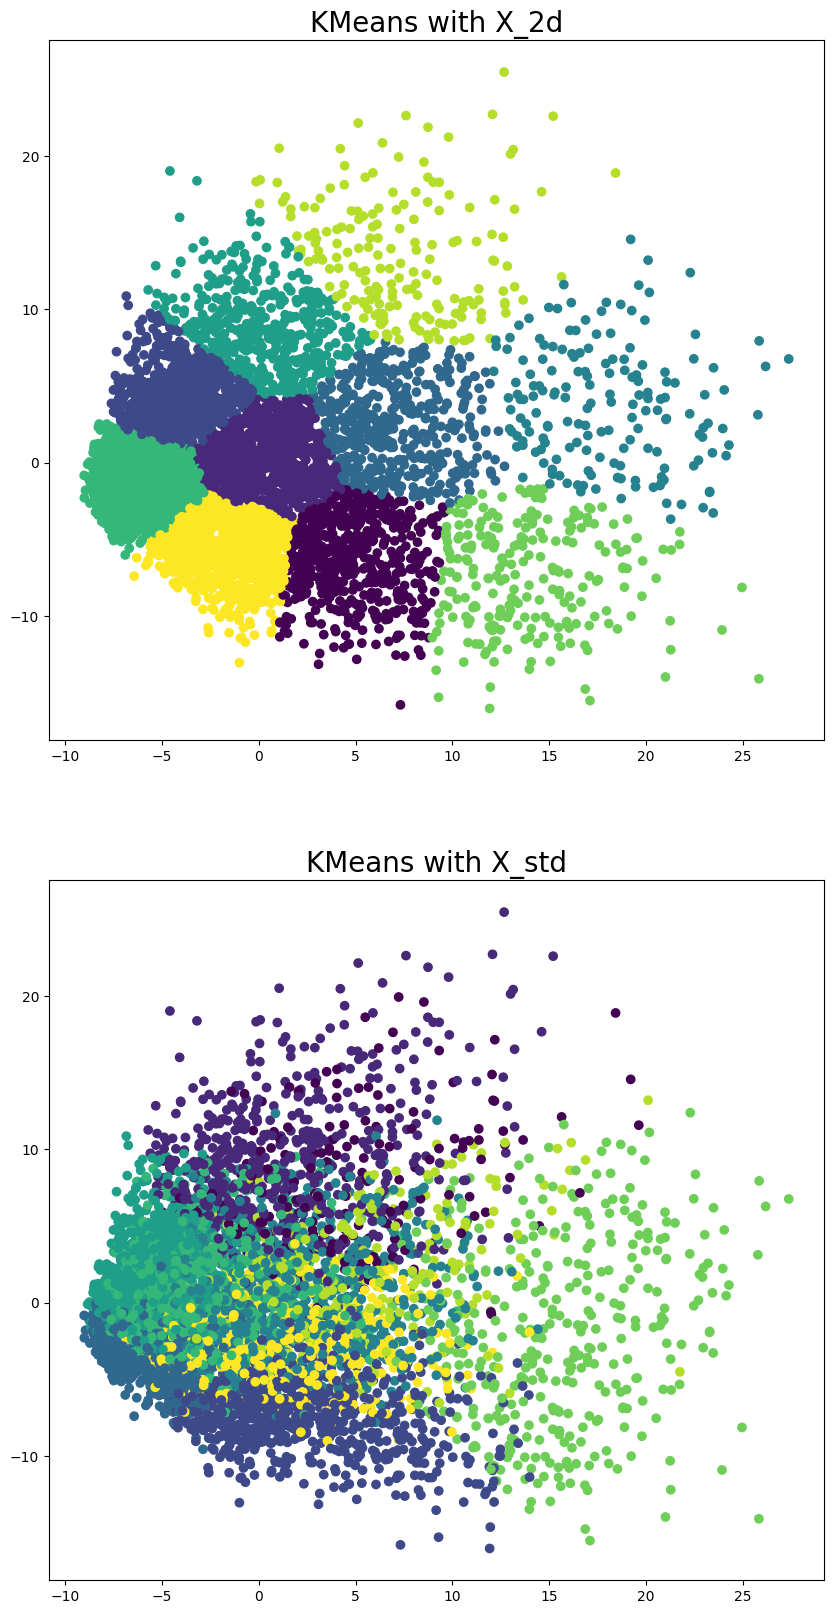

In [4]:
# TODO 对两种数据进行聚类，计算y_std与y_2d(1')
kmeans1 = KMeans(n_clusters=10).fit(X_std)
y_std = kmeans1.labels_
kmeans2 = KMeans(n_clusters=10).fit(X_2d)
y_2d = kmeans2.labels_

fig,ax=plt.subplots(2,1,figsize=(10,20))
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d)
ax[0].set_title('KMeans with X_2d',fontsize=20)
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y_std)
ax[1].set_title('KMeans with X_std',fontsize=20)
assert np.unique(y_std,return_counts=True)[1].mean() == 600
assert np.unique(y_2d,return_counts=True)[1].mean() == 600

In [5]:
# TODO: 计算两种聚类方法分别的纯度(1')与f1_score(1')
def purity(y_pred, y_true, k):
    n = len(y_pred)
    purity = 0
    for i in range(k):
        max_intersection = 0
        for j in range(k):
            intersection = np.logical_and(y_pred == i, y_true == j).sum()
            if intersection > max_intersection:
                max_intersection = intersection
        purity += max_intersection
    return purity / n

def f1_score(y_pred, y, n_clusters):
    f1_scores = []
    for i in range(n_clusters):
        fi = 0
        for r in range(n_clusters):
            tp = np.sum((y_pred == i) & (y == r))
            fp = np.sum((y_pred == i) & (y != r))
            fn = np.sum((y_pred != i) & (y == r))
            if tp == 0:
                continue
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)
            if f1 > fi:
                fi = f1
        f1_scores.append(fi)
    return np.array(f1_scores)

purity_std=purity(y_std, y[:,0],10)
f1_score_std=f1_score(y_std, y[:,0],10)
purity_2d=purity(y_2d, y[:,0],10)
f1_score_2d=f1_score(y_2d, y[:,0],10)

assert purity_std > 0.4
assert purity_2d > 0.3
assert f1_score_std.mean() > 0.4
assert f1_score_2d.mean() > 0.3

### 附加题(1分)请用KM算法等方式实现聚类结果和原标签的最优匹配，并在此基础上计算两种结果的F值。

参考阅读：

1. 匈牙利算法Wiki https://zh.wikipedia.org/wiki/%E5%8C%88%E7%89%99%E5%88%A9%E7%AE%97%E6%B3%95 
2. KM算法讲解 https://blog.csdn.net/sixdaycoder/article/details/47720471
3. KM算法python实现https://blog.csdn.net/weixin_39504758/article/details/120183504


In [6]:
print(np.shape(y_std))
print(np.shape(y[:,0]))
print(y_std[:30])
print(y[:,0][:30])

(6000,)
(6000,)
[2 7 1 3 5 2 5 2 5 6 4 3 0 9 5 6 8 3 9 6 0 7 6 3 5 4 5 4 0 3]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]


In [7]:
import numpy as np

def calc_KM(y_pred, y, n_clusters):
    # 构建混淆矩阵，记录每个类别的匹配数量
    graph = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for i in range(len(y)):
        graph[y[i], y_pred[i]] += 1

    # 使用Kuhn and Munkres算法求解最优匹配

    label_left, label_right = [max(g) for g in graph], [0 for _ in graph]
    S, T = {}, {}

    visited_left = [False for _ in graph]
    visited_right = [False for _ in graph]
    slack_right = [float('inf') for _ in graph]


    def find_path(i, visited_left, visited_right, slack_right):
        visited_left[i] = True
        for j, match_weight in enumerate(graph[i]):
            if visited_right[j]:
                continue
            gap = label_left[i] + label_right[j] - match_weight
            if gap == 0:
                visited_right[j] = True
                if j not in T or find_path(T[j], visited_left, visited_right, slack_right):
                    T[j] = i
                    S[i] = j
                    return True

            else:
                slack_right[j] = min(slack_right[j], gap)
        return False

    def KM():
        m = len(graph)
        for i in range(m):
            # 重置辅助变量
            slack_right = [float('inf') for _ in range(m)]
            while True:
                visited_left = [False for _ in graph]
                visited_right = [False for _ in graph]
                if find_path(i,visited_left,visited_right, slack_right):
                    break
                d = float('inf')
                for j, slack in enumerate(slack_right):
                    if not visited_right[j] and slack < d:
                        d = slack
                for k in range(m):
                    if visited_left[k]:
                        label_left[k] -= d
                    if visited_right[k]:
                        label_right[k] += d
        return S, T

    S,T=KM()
    
    # 构建匹配字典
    matching = {col: row for row, col in S.items()}

    # 使用匹配结果调整预测标签向量
    adjusted_y_pred = np.array([matching[y_pred[i]] for i in range(len(y))])

    # 返回调整后的预测标签向量
    return adjusted_y_pred







In [8]:
res_std=calc_KM(y_std,y[:,0],10)
f1_score_std = f1_score(res_std,y[:,0],10).mean()

res_2d=calc_KM(y_2d,y[:,0],10)
f1_score_2d = f1_score(res_2d,y[:,0],10).mean()

print(f1_score_std)
print(f1_score_2d)
assert f1_score_std > 0.4
assert f1_score_2d > 0.2

0.44309882314577836
0.31419679924804206


## 在下面的作业中，我们试图实现一个基于用户电影评价以及电影海报图片信息进行用户推荐的推荐系统。我们将会使用movielens-1M数据集，使用SVD,PCA等算法提取用户评分以及海报图片的特征，之后使用协同过滤算法进行推荐。**（为了方便出作业题，一些电影特征的合理性值得商榷，大家也可以思考一下有没有更好的特征）**

协同过滤算法中没有在作业中具体解释的相关代码不会要求同学们填写，以下为想要了解的同学提供一个较为简单的介绍。


协同过滤(Collaborative Filtering)是推荐系统中最常用的算法之一。它的核心思想是利用用户之间的相似性来为每个用户生成个性化的推荐。具体来说,协同过滤分为两种主要方法:基于用户(User-based)和基于物品(Item-based)。

基于用户的协同过滤的步骤如下:
1. 计算用户之间的相似度。常用的相似度度量有皮尔逊相关系数、余弦相似度等。
2. 对于每个用户,找到与其最相似的k个用户(称为k近邻)。
3. 根据k近邻的评分记录,为目标用户生成推荐。

基于物品的协同过滤的步骤类似,只是将用户之间的相似度换成了物品之间的相似度。

我们作业中使用的协同过滤方法是基于矩阵分解(Matrix Factorization)的隐语义模型,如奇异值分解(SVD)。这种方法将用户-物品评分矩阵分解为用户隐向量和物品隐向量的乘积,然后用这些隐向量预测缺失的评分。

为了评估协同过滤算法的性能,我们通常会使用两个评估指标：精确率(Precision)和召回率(Recall)。

精确率衡量的是推荐的物品中有多少是用户真正感兴趣的。
```
Precision = 推荐的物品中用户感兴趣的物品数 / 推荐的物品总数
```

召回率衡量的是用户感兴趣的物品中有多少被推荐系统找到了。
```
Recall = 推荐的物品中用户感兴趣的物品数 / 用户感兴趣的物品总数
```

在实践中,我们通常计算Top-N推荐的精确率和召回率,即为每个用户推荐N个物品,然后计算平均的精确率和召回率。（为了简便，本作业没有划分训练集和测试集，所以这里的精确率和召回率都是在训练集上的）

In [9]:
movies_df = pd.read_csv('./IMDB_SMALL/movies.csv')
rating_matrix = pd.read_csv('./IMDB_SMALL/ratings.csv', index_col=0) # 评分矩阵的行索引为用户ID，列索引为电影ID

## 一、电影海报图像聚类（2分）

### 从posters/目录读取所有海报图像,并将其转换为固定大小(60,40)的灰度图(注意x,y分别对应哪个坐标轴)，并将其展开成一维向量，将所有图像的向量拼接成一个矩阵，矩阵的大小为(图片数量, 60*40)。

In [10]:
movies_poster_features = []
posters = []
for movie_id in movies_df['movie_id']:
    poster_i = cv2.imread('./IMDB_SMALL/posters/' + str(movie_id) + '.jpg',cv2.IMREAD_COLOR)
    poster_i = cv2.cvtColor(poster_i, cv2.COLOR_BGR2GRAY)
    posters.append(movie_id)
    poster_i = cv2.resize(poster_i, (40,60))
    movies_poster_features.append(poster_i.reshape(-1))
movies_poster_features = np.array(movies_poster_features)

### 由于每个图片的像素特征可能过于复杂，我们可以使用PCA算法对图片进行降维。使用积分累加的方式，找到最小的k，使得前k个主成分的方差和占总方差的比例超过ratio，并输出k值以及最终PCA降维后的矩阵。（记得标准化）

In [11]:
def accu_pca(X,ratio):
    # TODO(1')
    pca = PCA(ratio)
    projected_X = pca.fit_transform(X)
    k = pca.n_components_
    
    return k, projected_X

In [12]:
pca_k, projected_movies_poster_features = accu_pca(movies_poster_features,0.9)
assert pca_k > 140 and pca_k < 250

### 使用KMeans算法（初始化使用kmeans++）对降维后的图片进行聚类，并可视化聚类结果。

Cluster 0:
[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
[3 'Grumpier Old Men (1995)' 'Comedy|Romance']
[10 'GoldenEye (1995)' 'Action|Adventure|Thriller']
[12 'Dracula: Dead and Loving It (1995)' 'Comedy|Horror']
[20 'Money Train (1995)' 'Action']


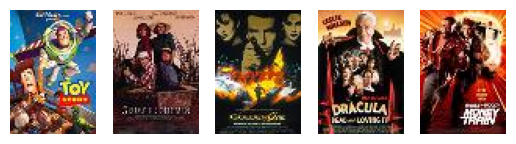

Cluster 1:
[5 'Father of the Bride Part II (1995)' 'Comedy']
[18 'Four Rooms (1995)' 'Thriller']
[19 'Ace Ventura: When Nature Calls (1995)' 'Comedy']
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
[53 'Lamerica (1994)' 'Drama']


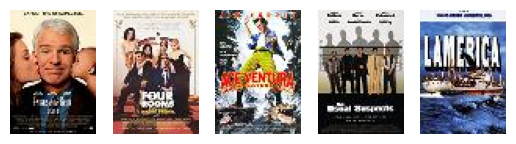

Cluster 2:
[2 'Jumanji (1995)' "Adventure|Children's|Fantasy"]
[6 'Heat (1995)' 'Action|Crime|Thriller']
[9 'Sudden Death (1995)' 'Action']
[11 'American President, The (1995)' 'Comedy|Drama|Romance']
[14 'Nixon (1995)' 'Drama']


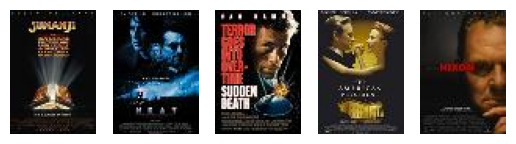

Cluster 3:
[7 'Sabrina (1995)' 'Comedy|Romance']
[8 'Tom and Huck (1995)' "Adventure|Children's"]
[13 'Balto (1995)' "Animation|Children's"]
[30 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)' 'Drama']
[36 'Dead Man Walking (1995)' 'Drama']


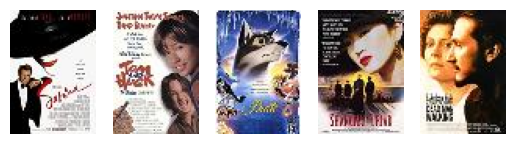

Cluster 4:
[4 'Waiting to Exhale (1995)' 'Comedy|Drama']
[15 'Cutthroat Island (1995)' 'Action|Adventure|Romance']
[27 'Now and Then (1995)' 'Drama']
[39 'Clueless (1995)' 'Comedy|Romance']
[71 'Fair Game (1995)' 'Action']


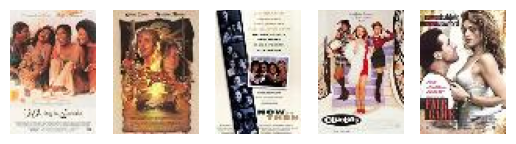

Cluster 5:
[17 'Sense and Sensibility (1995)' 'Drama|Romance']
[24 'Powder (1995)' 'Drama|Sci-Fi']
[38 'It Takes Two (1995)' 'Comedy']
[57 'Home for the Holidays (1995)' 'Drama']
[58 'Postino, Il (The Postman) (1994)' 'Drama|Romance']


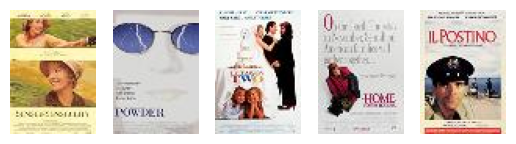

Cluster 6:
[74 'Bed of Roses (1996)' 'Drama|Romance']
[121 'Boys of St. Vincent, The (1993)' 'Drama']
[157 'Canadian Bacon (1994)' 'Comedy|War']
[254 'Jefferson in Paris (1995)' 'Drama']
[269 'My Crazy Life (Mi vida loca) (1993)' 'Drama']


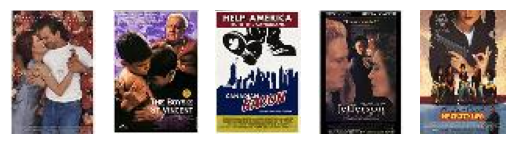

In [13]:
n_clusters = 7
# Kmeans++聚类
# TODO(1')
kmeans = KMeans(n_clusters=n_clusters).fit(projected_movies_poster_features)
labels = kmeans.labels_



# 可视化聚类结果
for i in range(n_clusters):
    print(f"Cluster {i}:")
    cnt = 0
    for j in range(len(labels)):
        if labels[j] == i:
            movie_id = posters[j]
            poster_i = cv2.imread('./IMDB_SMALL/posters/' + str(movie_id) + '.jpg',cv2.IMREAD_COLOR)
            print(movies_df[movies_df['movie_id'] == movie_id].values[0])
            plt.subplot(1, 5, cnt+1)
            plt.imshow(cv2.cvtColor(poster_i, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            cnt += 1
            if cnt == 5:
                break
    plt.show()
assert len(np.unique(labels)) == 7
assert len(labels) == 2925

### 

## 二、基于SVD、对用户电影评分数据进行协同过滤推荐（2分）

### 对用户-电影评分数据(rating_matrix)进行SVD分解，取top-k项，得到去除噪声后的用户偏好向量和电影特征向量，之后计算出用户对于电影的预测评分，最后根据预测评分进行推荐。

#### 关于用户偏好向量和电影特征向量: 
考虑用户-电影评分矩阵R=rating_matrix。R是一个m×n的矩阵,其中m是用户数,n是电影数,R[i, j]表示用户i对电影j的评分。如果我们对R进行SVD,得到:
```
R = U * Σ * V^T
```
那么,如果我们将Σ的对角元素记为σ_1, σ_2, ..., σ_r(其中r是R的秩),将U的第i列记为u_i,将V的第i列记为v_i:
```
R = σ_1 * u_1 * v_1^T + σ_2 * u_2 * v_2^T + ... + σ_r * u_r * v_r^T
```
每一项σ_i * u_i * v_i^T都捕捉了R中的一个潜在的用户-电影模式。u_i表示了这个模式中用户的偏好,v_i表示了这个模式中电影的特征,σ_i表示了这个模式的重要性。

所以,当我们用SVD分解评分矩阵R时,我们实际上是在寻找一组用户偏好向量和电影特征向量,它们的外积（也即预测评分矩阵）可以很好地近似原始的评分矩阵

也即**我们可以将U * Σ的行看作是用户评分的隐向量,将V的行看作是电影隐向量**。我们希望能够过滤掉评分矩阵中的噪声,所以我们只保留σ_i较大的那些模式(也即前top k个)。

In [14]:
# SVD分解(1')
svd_k = 100
svd = TruncatedSVD(n_components=svd_k)
user_vectors = svd.fit_transform(rating_matrix)
item_vectors = svd.components_.T

# 预测评分(1')
predicted_ratings = np.dot(user_vectors, item_vectors.T)

In [15]:
# 生成top-n推荐
def recommend_top_n(predicted_ratings, n=10):
    recommendations = {}
    for i in range(predicted_ratings.shape[0]):
        top_n = np.argsort(-predicted_ratings[i])[:n]
        recommendations[rating_matrix.index[i]] = rating_matrix.columns[top_n].tolist()
    return recommendations

top_n_recs = recommend_top_n(predicted_ratings)

# 计算precision@n和recall@n
def precision_recall_at_n(recommendations, n=10):
    precisions = []
    recalls = []
    for user, recs in recommendations.items():
        user_ratings = rating_matrix.loc[user]
        relevant_items = user_ratings[user_ratings > 0].index.tolist()
        
        intersection = set(recs[:n]).intersection(relevant_items)
        precisions.append(len(intersection) / n)
        recalls.append(len(intersection) / len(relevant_items))
        
    return np.mean(precisions), np.mean(recalls)
        
precision, recall = precision_recall_at_n(top_n_recs)
print(f"Precision@10: {precision:.3f}")  
print(f"Recall@10: {recall:.3f}")
assert precision > 0.9
assert recall > 0.1

Precision@10: 0.959
Recall@10: 0.142


## 三、基于HITS算法的电影重要性计算（2分）
### 在HITS算法中，我们将用户评分看作是用户对电影的一次引用，根据用户对电影的引用，我们可以计算出每部电影的hub和authority值，从而得到每部电影的重要性。

In [16]:
# TODO: 构建邻接矩阵adjacency_matrix (1')
def build_adjacency_matrix(rating_matrix):
    adj_matrix = np.dot(rating_matrix.T, rating_matrix)        
    return adj_matrix
adjacency_matrix = build_adjacency_matrix(rating_matrix)

# HITS算法
def HITS(A, max_iter=20, tol=1e-8):
    # TODO(1') max_iter次迭代,tol为判断是否收敛的delta阈值
    n = A.shape[0]
    h = np.ones(n)
    a = np.ones(n)
    for i in range(max_iter):
        h_new = np.dot(A.T, a)
        a_new = np.dot(A, h)
        h_new /= np.linalg.norm(h_new)
        a_new /= np.linalg.norm(a_new)
        if np.linalg.norm(h_new - h) < tol and np.linalg.norm(a_new - a) < tol:
            break
        h, a = h_new, a_new
        
    return h, a

In [17]:
h, a = HITS(adjacency_matrix)

# 按authority值排序并输出top-n
n = 10
top_movies = movies_df.iloc[np.argsort(-a)[:n]]
print(f"Top {n} movies by authority:")
print(top_movies['title'])

print("Analysis of top movies:")
print(top_movies.genres.str.split('|', expand=True).apply(pd.Series.value_counts).fillna(0).astype(int))
assert 888 in top_movies.index
assert top_movies.genres.str.split('|', expand=True).apply(pd.Series.value_counts).fillna(0).astype(int).iloc[0, 0] > 5

Top 10 movies by authority:
224             Star Wars: Episode IV - A New Hope (1977)
888     Star Wars: Episode V - The Empire Strikes Back...
2127                               American Beauty (1999)
890                        Raiders of the Lost Ark (1981)
1923                                   Matrix, The (1999)
508                      Silence of the Lambs, The (1991)
901     Star Wars: Episode VI - Return of the Jedi (1983)
1490                           Saving Private Ryan (1998)
518                                          Fargo (1996)
505                     Terminator 2: Judgment Day (1991)
Name: title, dtype: object
Analysis of top movies:
           0  1  2  3  4
Action     7  0  0  0  0
Adventure  0  4  0  0  0
Comedy     1  0  0  0  0
Crime      1  0  0  0  0
Drama      1  3  1  0  0
Fantasy    0  0  1  0  0
Romance    0  0  1  0  0
Sci-Fi     0  2  0  3  0
Thriller   0  1  3  0  0
War        0  0  1  0  2


## 四、混合推荐系统（附加题）（1分）

### 在混合推荐系统中，我们希望能够将用户对于电影的评分，电影内容本身的质量以及电影的重要性进行综合考虑，从而得到一个更加全面的推荐结果。
如何衡量电影内容本身的质量呢？我们可以将每部电影的基于评分的电影特征向量和PCA后的海报图像向量concate在一起作为该电影的特征之后进行聚类。

对于每个聚类，我们可以计算出用户对该类别电影的平均评价，从而得到每个电影类别的质量的评分。而对于每一部电影，我们可以计算出该电影距离每个聚类中心的距离，并对距离进行归一化，从而得到每部电影的基于内容的评分。

In [18]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
# TODO 将每部电影 基于评分的电影特征向量 和 PCA后的海报图像特征向量 concate在一起作为该电影的特征之后，进行聚类。


# 计算每个聚类的质量分数
cluster_quality = []
for i in range(n_clusters):
    cluster_movies = movies_df.iloc[labels == i]
    avg_rating = rating_matrix[list(map(str,cluster_movies['movie_id']))].mean().mean()
    cluster_quality.append(avg_rating)
cluster_quality = np.array(cluster_quality)

# 计算每部电影的隶属度分数
memberships = euclidean_distances(concat_feature, kmeans.cluster_centers_)
memberships = 1 / (1 + memberships)
memberships /= memberships.sum(axis=1, keepdims=True)

# 计算加权的基于内容评分
cb_ratings = np.dot(memberships, cluster_quality)
assert 0.3 < cb_ratings.mean() < 0.4

NameError: name 'concat_feature' is not defined

### 在得到了用户对于电影的评分，电影内容本身的评分以及电影的重要性之后，我们可以对这三个评分进行加权求和，从而得到混合的推荐评分。最后，我们可以对若干用户生成top-n推荐，并使用准确率precision@n和召回recall@n评估推荐质量。

In [ ]:
# 归一化
cf_ratings = (predicted_ratings - predicted_ratings.min()) / (predicted_ratings.max() - predicted_ratings.min())
cb_ratings = (cb_ratings - cb_ratings.min()) / (cb_ratings.max() - cb_ratings.min())
authority_scores = (a - a.min()) / (a.max() - a.min())
    
# 混合推荐评分
w1, w2, w3 = 0.6, 0.2, 0.2
mixed_ratings = # TODO 按照如上权重对三个评分进行加权

# 生成推荐并评估
mixed_top_n_recs = recommend_top_n(mixed_ratings)
mixed_precision, mixed_recall = precision_recall_at_n(mixed_top_n_recs)

print(f"Mixed recommender precision@10: {mixed_precision:.3f}")
print(f"Mixed recommender recall@10: {mixed_recall:.3f}")
assert mixed_precision > 0.7
assert mixed_recall > 0.08

Mixed recommender precision@10: 0.844
Mixed recommender recall@10: 0.109
